# Result analysis

## Loss

In [23]:
import glob
import json
import os

import matplotlib.pyplot as plt
import torch
from bouncing_ball.dataloaders.bouncing_data import BouncingBallDataLoader
from kalman_vae import KalmanVariationalAutoencoder
from natsort import natsorted

In [24]:
dtype = torch.float64
device = torch.device("cpu")

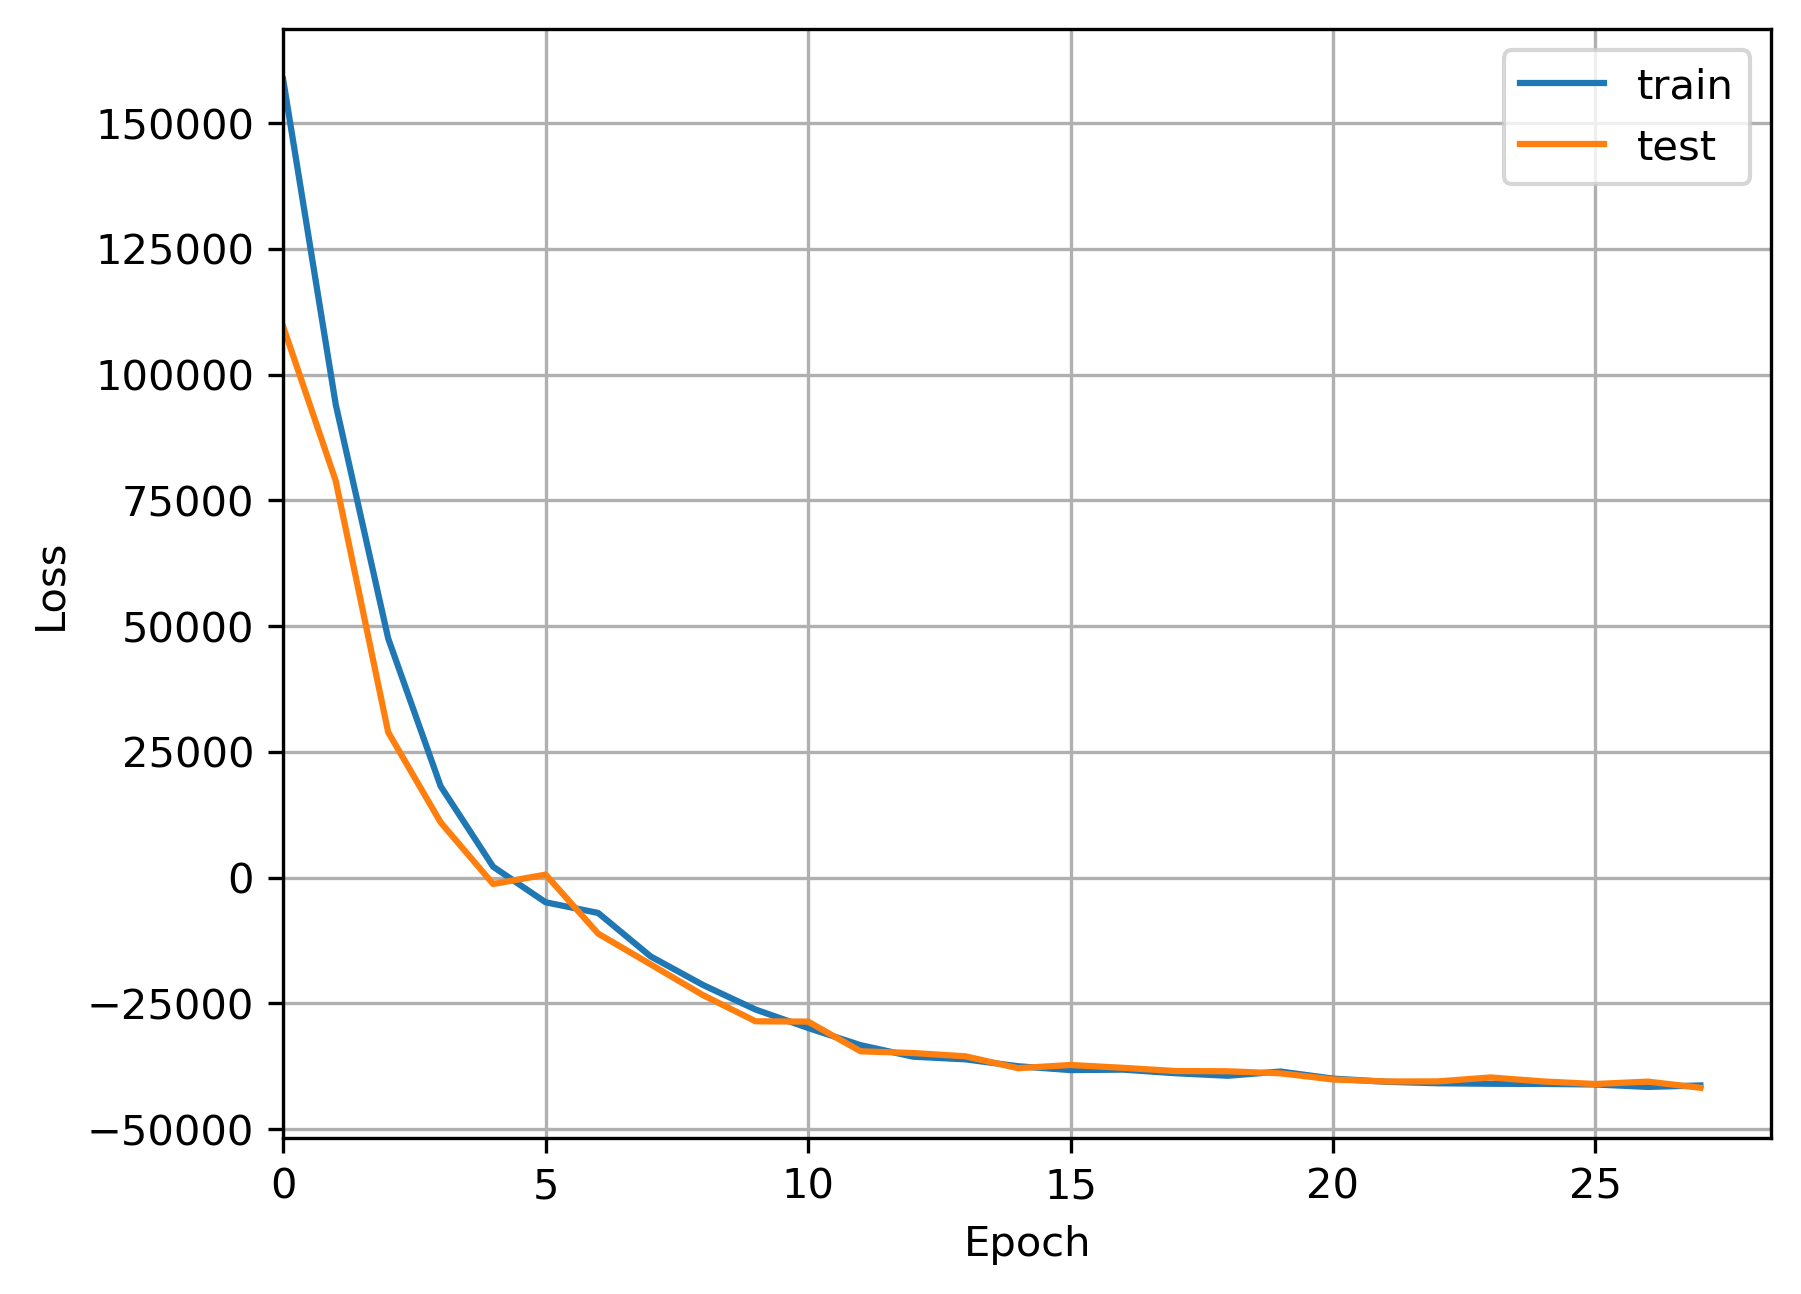

In [25]:
train_losses = []
test_losses = []

for file in natsorted(glob.glob(f"checkpoints/bouncing_ball_double_warmup-5_burnin-5/state-*.pth")):
    checkpoint = torch.load(file, map_location=device)
    train_losses.append(checkpoint["train_loss"])
    test_losses.append(checkpoint["test_loss"])

plt.figure(dpi=300)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.xlim(0, None)
# plt.yscale("log")
plt.show()

## Data visualization

In [26]:
data_index = 0

In [27]:
dataloader_test = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/test"
)
data = dataloader_test[data_index]

In [28]:
for i, data in enumerate(dataloader_test):
    print(data.shape)
    if i > 0:
        break

(50, 1, 16, 16)
(50, 1, 16, 16)


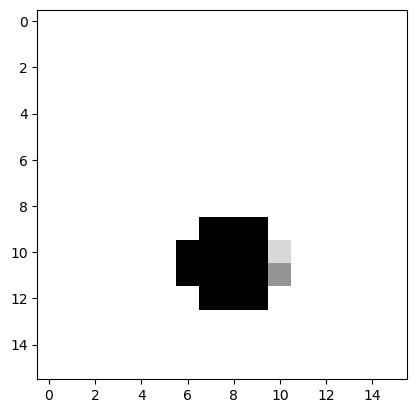

In [29]:
plt.imshow(data[0][0], vmin=0, vmax=1, cmap="Greys")

In [30]:
image_size = data.shape[2:]
image_channels = data.shape[1]

## Weights for transition matrix $A$

In [31]:
checkpoint = torch.load(file, map_location=device)

In [32]:
kvae = KalmanVariationalAutoencoder(
    image_size=image_size,
    image_channels=image_channels,
    a_dim=2,
    z_dim=4,
    K=3,
    decoder_type="bernoulli",
).to(dtype=dtype)

In [33]:
kvae.load_state_dict(checkpoint["model_state_dict"], strict=False)

<All keys matched successfully>

In [34]:
data_batch = torch.Tensor(data).unsqueeze(1).to(dtype=dtype)

In [35]:
data_batch.shape

torch.Size([50, 1, 1, 16, 16])

In [36]:
seq_length = data_batch.shape[0]
batch_size = data_batch.shape[1]

In [37]:
as_dist = kvae.encoder(data_batch.reshape(-1, *data_batch.shape[2:]))
as_mean = as_dist.loc.unsqueeze(1)

In [38]:
as_mean.shape

torch.Size([50, 1, 2])

In [39]:
weights = kvae.state_space_model.weight_model(as_mean)
reconstructions = kvae.decoder(as_mean).probs

In [40]:
reconstructions.shape

torch.Size([50, 1, 16, 16])

In [41]:
for step, (image, reconstruction, weight) in enumerate(
    zip(data_batch, reconstructions.detach().numpy(), weights)
):
    image = image > 0.5
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    fig.suptitle(f"$t = {step}$")
    axes[0].imshow(image[0][0], vmin=0, vmax=1, cmap="Greys", aspect="equal")
    axes[0].set_adjustable("box")
    axes[1].imshow(reconstruction[0], vmin=0, vmax=1, cmap="Greys", aspect="equal")
    axes[2].bar(["0", "1", "2"], weight[0].detach().numpy())
    axes[2].set_ylim(0, 1)
    axes[0].set_title(r"image $\mathbf{x}_t$")
    axes[1].set_title(r"reconstruction $\hat{\mathbf{x}}_t$")
    axes[2].set_title(r"weight $\mathbf{k}_t$")
    pos_img = axes[0].get_position()
    pos_bar = axes[2].get_position()
    axes[2].set_position([pos_bar.x0, pos_img.y0, pos_bar.width, pos_img.height])
    fig.savefig(f"analysis/weight-{step}.png")
    plt.close()

In [42]:
!ffmpeg -framerate 10 -i analysis/weight-%d.png -c:v libopenh264 -r 30 -pix_fmt yuv420p analysis/weights.mp4 -y

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566251848/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566251848/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --disable-gpl --enable-libaom --enable

In [43]:
from IPython.display import Video

Video("./analysis/weights.mp4")

## Future prediction

In [22]:
prediction = kvae.predict_future((data_batch > 0.5).to(dtype=dtype), num_steps=20)